In [36]:
import numpy as np
from tqdm import tqdm
from icecream import ic
import matplotlib.pyplot as plt
from matplotlib import cm
from mltools import plot_data, plot_frontiere, make_grid, gen_arti

def descente_gradient(datax, datay, f_loss, f_grad, eps, iter=1000):
    w_old = np.random.random(size=(datax.shape[1], 1))
    # w_old = np.zeros(datax.shape[1])
    w_list = [w_old]
    loss_list = [f_loss(w_old, datax, datay).mean()]
    for _ in tqdm(range(iter)):
        w = w_old - eps * f_grad(w_old, datax, datay).mean(axis=0).reshape(-1, 1)
        w_list.append(w)
        loss_list.append(f_loss(w, datax, datay).mean())

        if (np.abs((w - w_old)) < 1e-10).all():
            print(f'Convergence en {len(w_list)} itération')
            return w, w_list, loss_list
            
        w_old = w.copy()
    else:
        print(f"Non convergence en {len(w_list)}")
        return w, w_list, loss_list

In [53]:
def perceptron_loss(w, x, y):
    preds = x @ w
    return np.maximum(np.zeros_like(preds), - y * preds)

def perceptron_grad(w, x, y):
    n, d = x.shape
    zero_loss = np.nonzero(perceptron_loss(w, x, y) == 0)[0]
    grad = -y.reshape(n, 1) * x
    grad[zero_loss] = np.zeros(d)
    return grad

# perceptron_loss = lambda w, X, y: np.maximum(0, -y * (X@w))
# perceptron_grad = lambda w, X, y: ((-y * (X@w)) > 0) * (-y * X)

class Lineaire(object):
    def __init__(self, loss=perceptron_loss, loss_g=perceptron_grad, max_iter=100, eps=0.01):
        self.max_iter, self.eps = max_iter, eps
        self.w = None
        self.loss, self.loss_g = loss, loss_g

        self.w_list, self.loss_list = [], []

    def fit(self, datax, datay):
        self.w, self.w_list, self.loss_list = descente_gradient(
            datax, datay, self.loss, self.loss_g, self.eps, self.max_iter)

    def predict(self, datax):
        return np.sign(datax @ self.w).flatten()

    def score(self, datax, datay):
        y_hat = self.predict(datax)
        if datay.shape != y_hat.shape:
            datay = datay.flatten()
        return (np.where(datay == y_hat, 1, 0)/len(datay)).sum()


def load_usps(fn):
    with open(fn, "r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split()) > 2]
    tmp = np.array(data)
    return tmp[:, 1:], tmp[:, 0].astype(int)


def get_usps(l, datax, datay):
    if type(l) != list:
        resx = datax[datay == l, :]
        resy = datay[datay == l]
        return resx, resy
    tmp = list(zip(*[get_usps(i, datax, datay) for i in l]))
    tmpx, tmpy = np.vstack(tmp[0]), np.hstack(tmp[1])
    return tmpx, tmpy


def show_usps(data):
    plt.imshow(data.reshape((16, 16)), interpolation="nearest")


  0%|          | 0/2000 [00:00<?, ?it/s]

convergence


1.0000000000000002

[0.0, 0.0]


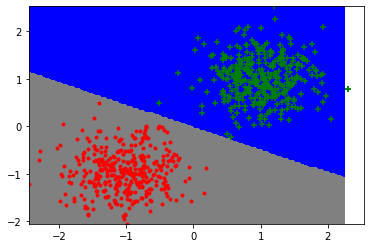

In [21]:
from mltools import *
from sklearn.model_selection import train_test_split

datax, datay = gen_arti(epsilon=0.3, data_type=0)
indices = np.arange(len(datax))
datax, testx, datay, testy = train_test_split(datax, datay)
grid, x_grid, y_grid = make_grid(xmin=-2, xmax=2, ymin=-2, ymax=2, step=100)
plt.figure()
plot_data(datax,datay)

lm = Lineaire(max_iter=2000)
lm.fit(datax, datay)
display(lm.score(datax, datay))

plot_frontiere(datax, lambda x: np.sign(x.dot(lm.w)), step=100)
plot_data(datax, datay)

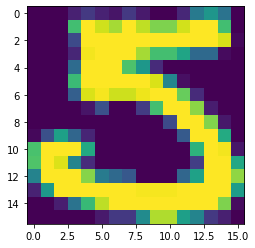

In [81]:
uspsdatatrain = "../data/USPS_train.txt"
uspsdatatest = "../data/USPS_test.txt"
alltrainx, alltrainy = load_usps(uspsdatatrain)
alltestx, alltesty = load_usps(uspsdatatest)
neg = 5
pos = 6
datax, datay = get_usps([neg, pos], alltrainx, alltrainy)
testx, testy = get_usps([neg, pos], alltestx, alltesty)

datay = np.where(datay==neg, 1, -1).reshape(-1, 1)
testy = np.where(testy==neg, 1, -1).reshape(-1, 1)
show_usps(datax[0])

100%|██████████| 150/150 [00:01<00:00, 141.30it/s]


Non convergence en 151


'Score en train 0.8213114754098361 ; Score en test 0.8393939393939392'

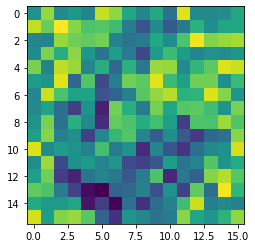

In [85]:
lm = Lineaire(max_iter=150)
lm.fit(datax, datay)
show_usps(lm.w)
f"Score en train {lm.score(datax, datay)} ; Score en test {lm.score(testx, testy)}"

100%|██████████| 10000/10000 [00:20<00:00, 481.43it/s]

Non convergence en 10001


'Score en train 0.9893442622950821 ; Score en test 0.9787878787878787'

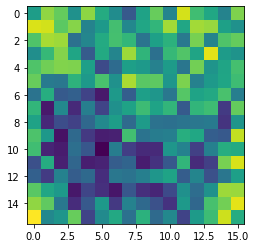

In [86]:
lm = Lineaire(max_iter=10000)
lm.fit(datax, datay)
show_usps(lm.w)
f"Score en train {lm.score(datax, datay)} ; Score en test {lm.score(testx, testy)}"

Quand on overfit les poids perdent leurs sens visuel mais on a des meilleurs score anyway

100%|██████████| 100/100 [00:00<00:00, 213.53it/s]

Non convergence en 101


'Score en train 0.9066265060240963 ; Score en test 0.8529411764705881'

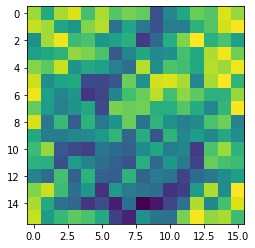

In [89]:
datax, datay = get_usps(6, alltrainx, alltrainy)
testx, testy = get_usps(6, alltestx, alltesty)
datay = np.where(datay==6, -1, 1).reshape(-1, 1)
testy = np.where(testy==6, -1, 1).reshape(-1, 1)
lm = Lineaire(max_iter=100)
lm.fit(datax, datay)
show_usps(lm.w)
f"Score en train {lm.score(datax, datay)} ; Score en test {lm.score(testx, testy)}"

In [ ]:
def descente_gradient_stoc(datax, datay, f_loss, f_grad, eps, iter=1000):
    w_old = np.random.random(size=(datax.shape[1], 1))
    # w_old = np.zeros(datax.shape[1])
    w_list = [w_old]
    loss_list = [f_loss(w_old, datax, datay).mean()]
    for _ in tqdm(range(iter)):

        i = np.random.randint(0, len(datax))
        x_i = datax[i]
        y_i = datay[i]

        w = w_old - eps * f_grad(w_old, x_i, y_i).mean(axis=0).reshape(-1, 1)
        w_list.append(w)
        loss_list.append(f_loss(w, datax, datay).mean())

        if (np.abs((w - w_old)) < 1e-10).all():
            print(f'Convergence en {len(w_list)} itération')
            return w, w_list, loss_list
            
        w_old = w.copy()
    else:
        print(f"Non convergence en {len(w_list)}")
        return w, w_list, loss_list

def descente_gradient_batch(datax, datay, f_loss, f_grad, eps, iter=1000, batch_size=100):
    w_old = np.random.random(size=(datax.shape[1], 1))
    # w_old = np.zeros(datax.shape[1])
    w_list = [w_old]
    loss_list = [f_loss(w_old, datax, datay).mean()]
    for _ in tqdm(range(iter)):

        i = np.random.randint(0, len(datax))
        x_i = datax[i]
        y_i = datay[i]

        w = w_old - eps * f_grad(w_old, x_i, y_i).mean(axis=0).reshape(-1, 1)
        w_list.append(w)
        loss_list.append(f_loss(w, datax, datay).mean())

        if (np.abs((w - w_old)) < 1e-10).all():
            print(f'Convergence en {len(w_list)} itération')
            return w, w_list, loss_list
            
        w_old = w.copy()
    else:
        print(f"Non convergence en {len(w_list)}")
        return w, w_list, loss_list